In [108]:
from collections.abc import Iterable
from copy import deepcopy
from random import randint
from typing import List

import matplotlib.pyplot as plt
import networkx as nx
import torch
from tqdm.notebook import trange, tqdm

from graph import create_graph, milp_solve, mdsi
from pyg import geom_data

In [161]:
ckp_path = './experiments/2024-06-02 1211/0/checkpoints/epoch=275-step=2207999.ckpt'
checkpoint = torch.load(ckp_path, map_location=torch.device('cpu'))
hyper_parameters = checkpoint['hyper_parameters']

solver = milp_solve
indexer = mdsi

In [162]:
from models import GNNModel

replace_weight_key = False
transpose = False

state_dict = {}
for k, v in checkpoint['state_dict'].items():
    if replace_weight_key:
        k = k.replace('.weight', '.lin.weight')
    k = k.replace('model.', '')
    if (k == 'layers.0.lin.weight' or 'output_layers' in k) and transpose:
        v = v.T
    state_dict[k] = v

gnn = GNNModel(c_in=hyper_parameters['c_in'], c_hidden=30, c_out=hyper_parameters['c_out'], num_layers=hyper_parameters['num_layers'],
               m=hyper_parameters['m'], dp_rate=0)
gnn.load_state_dict(state_dict)
gnn.eval()
gnn

GNNModel(
  (layers): ModuleList(
    (0): GCNConv(1, 30)
    (1): ReLU(inplace=True)
    (2): GCNConv(30, 30)
    (3): ReLU(inplace=True)
    (4): GCNConv(30, 30)
    (5): ReLU(inplace=True)
    (6): GCNConv(30, 30)
    (7): ReLU(inplace=True)
    (8): GCNConv(30, 30)
    (9): ReLU(inplace=True)
    (10): GCNConv(30, 30)
    (11): ReLU(inplace=True)
    (12): GCNConv(30, 30)
    (13): ReLU(inplace=True)
    (14): GCNConv(30, 30)
    (15): ReLU(inplace=True)
    (16): GCNConv(30, 30)
    (17): ReLU(inplace=True)
    (18): GCNConv(30, 30)
    (19): ReLU(inplace=True)
    (20): GCNConv(30, 30)
    (21): ReLU(inplace=True)
    (22): GCNConv(30, 30)
    (23): ReLU(inplace=True)
    (24): GCNConv(30, 30)
    (25): ReLU(inplace=True)
    (26): GCNConv(30, 30)
    (27): ReLU(inplace=True)
    (28): GCNConv(30, 30)
    (29): ReLU(inplace=True)
    (30): GCNConv(30, 30)
    (31): ReLU(inplace=True)
    (32): GCNConv(30, 30)
    (33): ReLU(inplace=True)
    (34): GCNConv(30, 30)
    (35): ReLU(i

In [76]:
n, p = 10, .15
g = create_graph(n, p)
# g = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]])
edge_list = [(int(a), int(b)) for a, b in g.T]

g_n = nx.from_edgelist(edge_list)
idx_t = torch.Tensor([[i] for i in range(n)])
x = torch.Tensor([[1.]]*n)
x = torch.stack([idx_t, x], dim=1)
tg = geom_data.Data(x=x, edge_index=g)
g_n = nx.from_edgelist(edge_list)
g_n.x = x
g_n.edge_list = g

In [77]:
def forward(gnn, g: nx.Graph):
    """
    return
     - prob_maps: lists of sorted vertices by prob
     - maps: truncated maps
     - id_better_solution
    """
    prob_maps = gnn.forward(g.x[:, 1], g.edge_list)
    maps = (torch.sigmoid(prob_maps) > .5).float()

    cov_size, uncovered_nodes, best_sol_id = mdsi(maps, g.edge_list)

    prob_maps = prob_maps.squeeze(2).tolist()
    sorted_prob_maps = []
    for pb_m in prob_maps:
        prob = list(enumerate(pb_m))
        prob.sort(key=lambda x: x[1], reverse=True)
        sorted_prob_maps.append(prob)

    return sorted_prob_maps, maps, best_sol_id


In [78]:
mvc = solver(g, n)
y = torch.FloatTensor([[n in mvc] for n in range(n)])
print(f'{mvc=}')

sorted_prob_maps, maps, id_min_mvci = forward(gnn, g_n)

mvc={0, 1, 5, 6, 8}


In [79]:
acc = ((maps == y).sum(dim=1) / y.size(dim=0)).max().item()
aon = (maps == y).all(dim=1).sum().float().item()

a, b = 1, 1
cov_size_dif = (maps.sum(dim=1) - y.sum())
uncovered_edges = torch.sum(
    ~(maps[:, g[0]].logical_or(maps[:, g[1]])),
    dim=1
) / 2
mvc_scores = (a * cov_size_dif.abs() + b * uncovered_edges)
idx, min_mvc = mvc_scores.argmin().item(), mvc_scores.min().item()

print(f'{acc=:.2f}\n{aon=}\n{min_mvc=} \n{cov_size_dif[idx]=} \n{uncovered_edges[idx]=}')

acc=1.00
aon=2.0
min_mvc=0.0 
cov_size_dif[idx]=tensor([0.]) 
uncovered_edges[idx]=tensor([0.])


In [80]:
def mvc_simple(gnn: GNNModel, g: nx.Graph) -> set:
    g_ = deepcopy(g)
    sorted_prob_maps, _, id_min_mvci = forward(gnn, g_)
    s = set()
    while g_.edges:
        n_s = set()
        for v, _ in sorted_prob_maps[id_min_mvci]:
            if v in s | n_s or v not in g_:
                continue

            s.add(v)
            for u in list(g_[v]):
                n_s.add(u)
                # preventing lonely node after v removed
                if len(g_[u]) == 1:
                    g_.remove_node(u)

            g_.remove_node(v)
    return s

s = mvc_simple(gnn, g_n)
s, len(s) == len(mvc), all(u.item() in s or v.item() in s for u, v in g.T)

({1, 4, 5, 8, 9}, True, True)

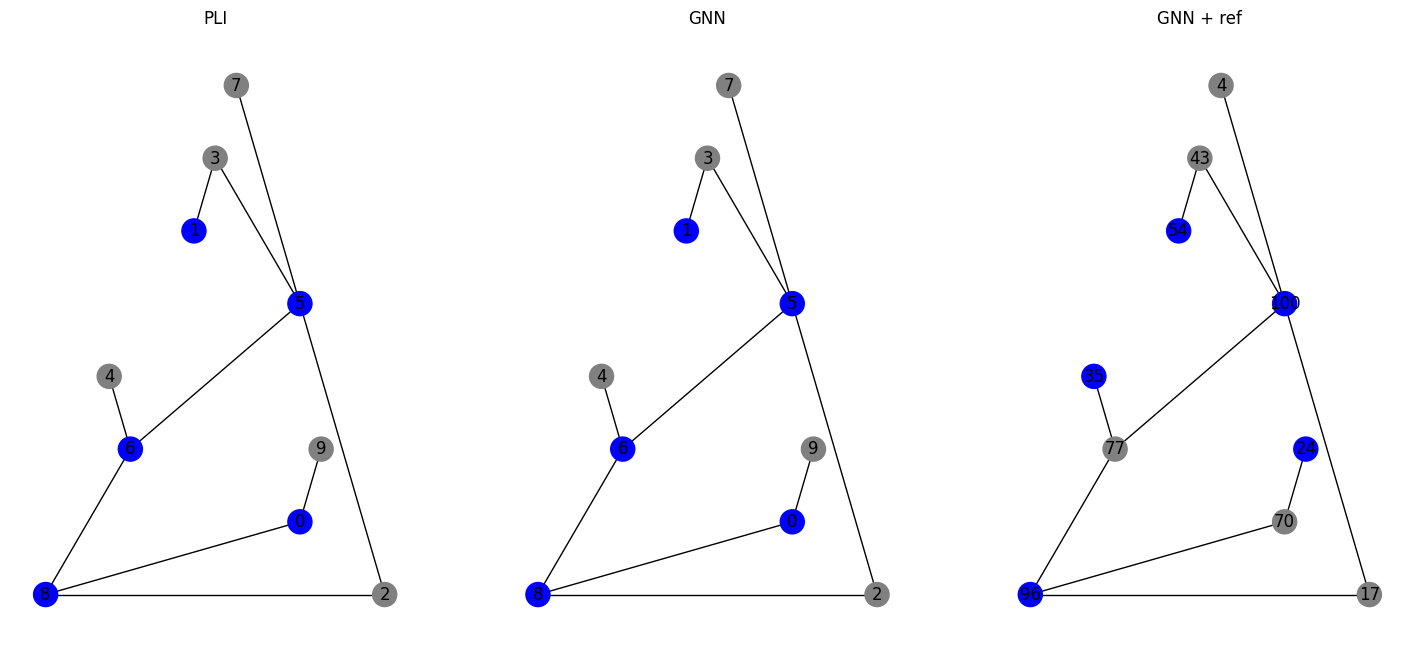

In [81]:
plt.ioff()

layout = None
try:
    layout = nx.planar_layout(g_n)
except:
    pass

fig, axes = plt.subplots(ncols=3, figsize=(18, 8))

node_colors = ['blue' if n in mvc else 'gray' for n in g_n]
nx.draw(g_n, with_labels=True, node_color=node_colors, pos=layout, ax=axes[0])

mvc_color = ['blue' if v else 'gray' for v in maps[id_min_mvci].squeeze()]
node_colors = [mvc_color[n] for n in g_n]
nx.draw(g_n, with_labels=True, node_color=node_colors, pos=layout, ax=axes[1])

mvc_color = ['blue' if v in s else 'gray' for v in range(n)]
node_colors = [mvc_color[n] for n in g_n]
probs = torch.sigmoid(torch.tensor([p for idx, p in sorted_prob_maps[id_min_mvci]])).tolist()
label_dict = {n: f'{v*100:.0f}' for (n, _), v in zip(sorted_prob_maps[id_min_mvci], probs)}
nx.draw(g_n, with_labels=True, node_color=node_colors, pos=layout, ax=axes[2], labels=label_dict)

for i, t in enumerate(['PLI', 'GNN', 'GNN + ref']):
    axes[i].set_title(t)

plt.show()

In [82]:
# raise KeyError

## Correct output distribution

In [83]:
tt_g = 1000
l = torch.nn.BCEWithLogitsLoss()
m = hyper_parameters['m']
x = torch.Tensor([[1.]] * n)

results = [0] * m
r_l = [0] * m
gnn_ref_ltq_mvc = [False] * tt_g
gnn_ref_cv = [False] * tt_g  # if the solution is a vertex cover

for i in trange(tt_g):
    g = create_graph(n, p)
    edge_list = [(int(a), int(b)) for a, b in g.T]
    x = torch.Tensor([[1.]]*n)
    g_n = nx.from_edgelist(edge_list)
    g_n.x = x
    g_n.edge_list = g

    mvc = solver(g, n)
    y = torch.FloatTensor([[n in mvc] for n in range(n)])

    prob_maps = gnn.forward(x, g)
    losses = [l(pb, y) for pb in prob_maps]
    r_l_idx = min(range(m), key=lambda x: losses[x])
    r_l[r_l_idx] += 1
    maps = (torch.sigmoid(prob_maps) > .5).float()

    a, b = 1, 1
    cov_size_dif = (maps.sum(dim=1) - y.sum()).abs()
    uncovered_edges = torch.sum(
        ~(maps[:, g[0]].logical_or(maps[:, g[1]])),
        dim=1
    )
    mvc_scores = (a * cov_size_dif + b * uncovered_edges)
    idx = mvc_scores.argmin()
    results[idx] += 1

    idx_t = torch.Tensor([[i] for i in range(n)])
    x = torch.Tensor([[1.]]*n)
    x = torch.stack([idx_t, x], dim=1)
    g_n.x = x
    s = mvc_simple(gnn, g_n)
    gnn_ref_ltq_mvc[i] = len(s) <= len(mvc)

    gnn_ref_cv[i] = all(u in s or v in s for u, v in edge_list)

results

  0%|          | 0/1000 [00:00<?, ?it/s]

[432, 28, 46, 75, 7, 12, 3, 4, 27, 5, 64, 284, 5, 6, 0, 2]

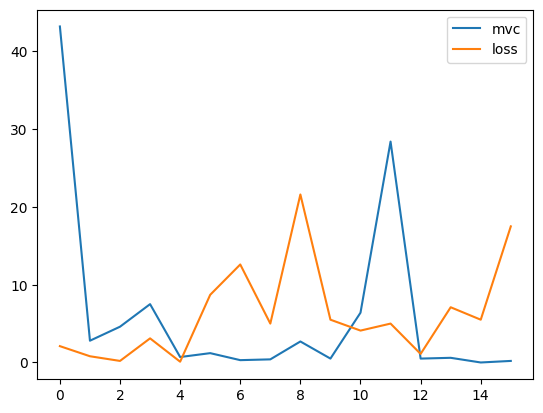

In [84]:
import pandas as pd
fig.clear()
pd.DataFrame({'mvc': [r/10 for r in results], 'loss': [r/10 for r in r_l]}).plot()
plt.show()

In [85]:
sum(gnn_ref_ltq_mvc)/tt_g, sum(gnn_ref_cv)/tt_g

(0.793, 1.0)

## Recursive MVC

In [86]:
def tensor_pop(t, ids):
    if not isinstance(ids, Iterable):
        ids = [ids]

    index = t[:,0, 0]
    mask = torch.tensor([i in ids for i in index])
    t[mask, 1, 0] = 0

    return t

def ei_remove_node(edge_index, node):
    mask = (edge_index[0] != node) & (edge_index[1] != node)
    new_edge_index = edge_index[:, mask]
    return new_edge_index

def remove_node(g: nx.Graph, n: int):
    g.remove_node(n)
    g.x = tensor_pop(g.x, n)
    g.edge_list = ei_remove_node(g.edge_list, n)
    return g

In [87]:
def mvc_r(gnn, g: nx.Graph, y: List[bool]):
    g_ = deepcopy(g)
    sorted_prob_maps, _, id_min_mvci = forward(gnn, g_)
    s = set()
    n_s = set()
    for v, p in sorted_prob_maps[id_min_mvci]:
        if v in s | n_s:
            break
        if v not in g_:
            # this can happen in a recursive call because the input x is not resized
            # to avoid problems with the vector indices on the edge_index,
            # given that it keep vertex with index > len(x) if x was decreased.
            # it could be faster to remove the indices from X and ajust the edge_index
            # to avoid passing unecessary nodes to the network
            continue

        s.add(v)
        for u in list(g_[v]):
            n_s.add(u)
            # preventing lonely node after v removed
            if len(g_[u]) == 1:
                g_ = remove_node(g_, u)

        g_ = remove_node(g_, v)

    if g_:
        s |= mvc_r(gnn, g_, y)

    return s

In [88]:
idx_t = torch.Tensor([[i] for i in range(n)])
x = torch.Tensor([[1.]]*n)
x = torch.stack([idx_t, x], dim=1)
g = create_graph(n, p)
edge_list = [(int(a), int(b)) for a, b in g.T]
g_n = nx.from_edgelist(edge_list)
g_n.x = x
g_n.edge_list = g

mvc = solver(g, n)
y = torch.FloatTensor([[n in mvc] for n in range(n)])

solution = mvc_r(gnn, g_n, y)

print(mvc, solution)
print(f'same size? {len(mvc) == len(solution)}')

{1, 3, 6, 7, 8} {1, 2, 6, 7, 8}
same size? True


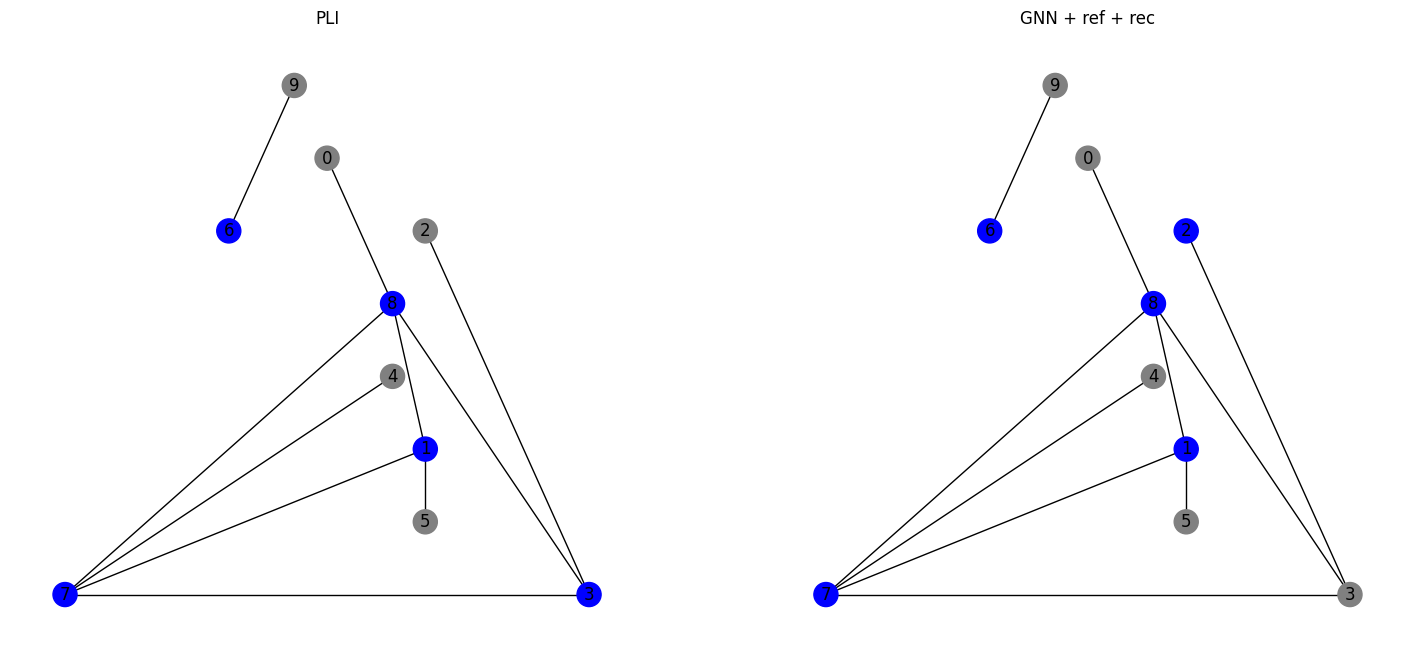

In [89]:
layout = None
try:
    layout = nx.planar_layout(g_n)
except:
    pass

fig, axes = plt.subplots(ncols=2, figsize=(18, 8))

node_colors = ['blue' if n in mvc else 'gray' for n in g_n]
nx.draw(g_n, with_labels=True, node_color=node_colors, pos=layout, ax=axes[0])

node_colors = ['blue' if n in solution else 'gray' for n in g_n]
nx.draw(g_n, with_labels=True, node_color=node_colors, pos=layout, ax=axes[1])

for i, t in enumerate(['PLI', 'GNN + ref + rec']):
    axes[i].set_title(t)

plt.show()

### Tree Search

In [136]:
# raise KeyError

def tree_search(gnn, g: nx.Graph, y, max_expansions=10):
    g.s = set()
    bag = [g]
    best = set(g.nodes)

    expansions = 0
    while len(best) > y.sum() and expansions < max_expansions and bag:
        g_id = randint(0, len(bag)-1)
        g = bag.pop(g_id)
        prob_maps, _, _ = forward(gnn, g)

        for m in prob_maps:
            s = set()
            g_ = deepcopy(g)
            n_s = set()
            for v, _ in m:
                if v in s | n_s or v not in g_:
                    break

                s.add(v)
                for u in list(g_[v].keys()):
                    n_s.add(u)
                    if len(g_[u]) == 1:
                        g_ = remove_node(g_, u)

                g_ = remove_node(g_, v)

            new_mvc = s | g_.s
            if not g_.edges:
                if len(new_mvc) < len(best):
                    best = new_mvc
            else:
                g_.s = new_mvc
                # TODO update g_.x and g_.edge_list
                bag.append(g_)

        expansions += 1

    return best

In [91]:
idx_t = torch.Tensor([[i] for i in range(n)])
x = torch.Tensor([[1.]]*n)
x = torch.stack([idx_t, x], dim=1)
g = create_graph(n, p)
edge_list = [(int(a), int(b)) for a, b in g.T]
g_n = nx.from_edgelist(edge_list)
g_n.x = x
g_n.edge_list = g

mvc = solver(g, n)
y = torch.FloatTensor([[n in mvc] for n in range(n)])

solution = tree_search(gnn, g_n, y)

mvc, solution

({0, 1, 2, 4, 8}, {0, 1, 2, 4, 8})

## Methods Comparison

In [163]:
from graph import clustering_coefficient

method_by_id = {0: mvc_simple, 1: mvc_r, 2: tree_search}
valid_cvr:    List[bool] = [[], [], []]
size_eq_mlip: List[bool] = [[], [], []]

tt_g = 10000
graphs = []
max_d = 0
for i in trange(tt_g):
    edge_index = create_graph(n, p)
    idx_t = torch.Tensor([[i] for i in range(n)])
    x =  torch.Tensor([[1.] for i in range(n)])
    # x = clustering_coefficient(edge_index)[:, 1].unsqueeze(1)
    # d_g = x.max().item()
    # if d_g > max_d:
    #     max_d = d_g
    x = torch.stack([idx_t, x], dim=1)
    edge_list = [(int(a), int(b)) for a, b in edge_index.T]
    g_n = nx.from_edgelist(edge_list)
    g_n.x = x
    g_n.edge_list = edge_index
    graphs.append(g_n)

for g_n in tqdm(graphs):
    # g_n.x[:, 1] = g_n.x[:, 1]/max_d
    mvc = solver(g_n.edge_list, n)
    y = torch.FloatTensor([[n in mvc] for n in range(n)])

    for m_id, func in method_by_id.items():
        if m_id == 0:
            s = func(gnn, g_n)
        else:
            s = func(gnn, g_n, y)
        valid_cvr[m_id].append(all(u in s or v in s for u, v in edge_list))
        size_eq_mlip[m_id].append(len(s) <= len(mvc))

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [164]:
graphs[1].x[:, 1]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [165]:
for m_id, func in method_by_id.items():
    print(f'{func.__name__:<15} {100*sum(valid_cvr[m_id])/tt_g}% valid MVC      {100*sum(size_eq_mlip[m_id])/tt_g}% equivalent to MILP')

mvc_simple      2.49% valid MVC      78.62% equivalent to MILP
mvc_r           0.92% valid MVC      99.21% equivalent to MILP
tree_search     5.57% valid MVC      88.82% equivalent to MILP


In [ ]:
method_by_id = {0: mvc_simple, 1: mvc_r, 2: tree_search}
valid_cvr    = [[], [], []]
size_eq_mlip = [[], [], []]

tt_g = 1000
n = 15
for i in trange(tt_g):
    idx_t = torch.Tensor([[i] for i in range(n)])
    x = torch.Tensor([[1.]]*n)
    x = torch.stack([idx_t, x], dim=1)
    g = create_graph(n, p)
    edge_list = [(int(a), int(b)) for a, b in g.T]
    g_n = nx.from_edgelist(edge_list)
    g_n.x = x
    g_n.edge_list = g

    mvc = solver(g, n)
    y = torch.FloatTensor([[n in mvc] for n in range(n)])

    for m_id, func in method_by_id.items():
        s = func(gnn, g_n, y)
        valid_cvr[m_id].append(all(u in s or v in s for u, v in edge_list))
        size_eq_mlip[m_id].append(len(s) <= len(mvc))

for m_id, func in method_by_id.items():
    print(f'{func.__name__:<15} {100*sum(valid_cvr[m_id])/tt_g}% valid MVC      {100*sum(size_eq_mlip[m_id])/tt_g}% equivalent to MILP')